In [9]:
from google.colab import drive
drive.mount('/content/drive')

import os, torch, json, shutil, numpy as np, pandas as pd
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

# Define file paths
train_csv_path = "/content/drive/MyDrive/Dataset/train/other/train.csv"
label_map_path = "/content/drive/MyDrive/Dataset/train/other/label_num_to_disease_map.json"
train_images_path = "/content/drive/MyDrive/Dataset/train/train_data"
model_save_path = "/content/drive/MyDrive/Dataset/train/crop_disease_models"

# Create model save directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# =======================
# Use CustomDataset
# =======================
ds = CustomDataset(root=train_images_path, csv_path=train_csv_path, transform=tfs)

# =======================
# Split dataset: train, val, test (80%, 10%, 10%)
# =======================
total_size = len(ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # ensures sum matches

train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

# =======================
# Create DataLoaders
# =======================
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Dataset size: {total_size}")
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Dataset size: 21397
Train: 17117, Val: 2139, Test: 2141


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # after 3 poolings, image size reduces from 224→28 (224/2/2/2 = 28)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(x.size(0), -1)             # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [20]:
# =======================
# Subset split (1000 train, 10 val, 200 test)
# =======================

total_size = len(ds)  # full dataset size (21397)
subset_size = 1000 + 10 + 200  # 1210

# First shrink dataset down to 1210 samples
small_ds, _ = random_split(ds, [subset_size, total_size - subset_size])

# Now split small_ds into train, val, test
train_size, val_size, test_size = 1000, 10, 200
train_ds, val_ds, test_ds = random_split(small_ds, [train_size, val_size, test_size])

# =======================
# Create DataLoaders
# =======================
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=10, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# =======================
# Debug prints
# =======================
print("Total dataset:", total_size)
print(f"Subset -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Total dataset: 21397
Subset -> Train: 1000, Val: 10, Test: 200


In [24]:
# =======================
# Imports
# =======================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from PIL import Image
import pandas as pd
import json

# =======================
# Paths
# =======================
train_csv_path = "/content/drive/MyDrive/Dataset/train/other/train.csv"
train_images_path = "/content/drive/MyDrive/Dataset/train/train_data"
label_map_path = "/content/drive/MyDrive/Dataset/train/other/label_num_to_disease_map.json"

# =======================
# Load class labels
# =======================
try:
    with open(label_map_path, "r") as f:
        label_map = json.load(f)
    classes = list(label_map.values())
except:
    df = pd.read_csv(train_csv_path)
    classes = df.iloc[:, 1].unique().tolist()

num_classes = len(classes)
print(f"Number of classes: {num_classes}")

# =======================
# Custom Dataset
# =======================
class CustomDataset(Dataset):
    def __init__(self, root, csv_path, transform=None):
        self.root = root
        self.transform = transform
        self.data = pd.read_csv(csv_path)

        # Keep only existing files
        self.data = self.data[self.data.iloc[:, 0].apply(
            lambda x: os.path.exists(os.path.join(self.root, x))
        )].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.root, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# =======================
# Transformations
# =======================
im_size = 224
tfs = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# =======================
# Load Dataset
# =======================
ds = CustomDataset(root=train_images_path, csv_path=train_csv_path, transform=tfs)
print(f"Total dataset: {len(ds)}")

# =======================
# Subset Split: 1000 / 10 / 200
# =======================
subset_size = 1000 + 10 + 200
total_size = len(ds)
small_ds, _ = random_split(ds, [subset_size, total_size - subset_size])
train_ds, val_ds, test_ds = random_split(small_ds, [1000, 10, 200])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=10, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Subset sizes -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# =======================
# Custom CNN
# =======================
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# =======================
# Training setup
# =======================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
steps_per_epoch = 40 // train_loader.batch_size + 1  # ~40 images per epoch

# =======================
# Training loop
# =======================
# =======================
# Training loop with detailed logs
# =======================
for epoch in range(epochs):
    model.train()
    running_loss, running_correct, processed_images = 0.0, 0, 0

    print(f"\n=== Epoch {epoch+1}/{epochs} ===")

    for step, (imgs, labels) in enumerate(train_loader):
        if step >= steps_per_epoch:  # only ~40 images per epoch
            break

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(1) == labels).sum().item()
        processed_images += batch_size

        print(f"Batch {step+1}/{steps_per_epoch} | "
              f"Batch Loss: {loss.item():.4f} | "
              f"Cumulative Loss: {running_loss/processed_images:.4f} | "
              f"Cumulative Acc: {running_correct/processed_images:.4f} | "
              f"Images Processed: {processed_images}")

    epoch_loss = running_loss / processed_images
    epoch_acc  = running_correct / processed_images

    print(f"--- Epoch {epoch+1} Summary ---")
    print(f"Average Loss: {epoch_loss:.4f} | Average Accuracy: {epoch_acc:.4f}")
    print("="*50)



Number of classes: 5
Total dataset: 16898
Subset sizes -> Train: 1000, Val: 10, Test: 200

=== Epoch 1/10 ===
Batch 1/2 | Batch Loss: 1.6287 | Cumulative Loss: 1.6287 | Cumulative Acc: 0.0938 | Images Processed: 32
Batch 2/2 | Batch Loss: 3.5106 | Cumulative Loss: 2.5697 | Cumulative Acc: 0.3438 | Images Processed: 64
--- Epoch 1 Summary ---
Average Loss: 2.5697 | Average Accuracy: 0.3438

=== Epoch 2/10 ===
Batch 1/2 | Batch Loss: 1.3837 | Cumulative Loss: 1.3837 | Cumulative Acc: 0.5000 | Images Processed: 32
Batch 2/2 | Batch Loss: 1.5907 | Cumulative Loss: 1.4872 | Cumulative Acc: 0.3125 | Images Processed: 64
--- Epoch 2 Summary ---
Average Loss: 1.4872 | Average Accuracy: 0.3125

=== Epoch 3/10 ===
Batch 1/2 | Batch Loss: 1.4784 | Cumulative Loss: 1.4784 | Cumulative Acc: 0.5625 | Images Processed: 32
Batch 2/2 | Batch Loss: 1.4555 | Cumulative Loss: 1.4670 | Cumulative Acc: 0.5156 | Images Processed: 64
--- Epoch 3 Summary ---
Average Loss: 1.4670 | Average Accuracy: 0.5156

===

Epoch 1/10 - Loss: 1.2102 - Acc: 0.5781
Epoch 2/10 - Loss: 1.3012 - Acc: 0.5625
Epoch 3/10 - Loss: 1.1445 - Acc: 0.6875
Epoch 4/10 - Loss: 1.1192 - Acc: 0.6562
Epoch 5/10 - Loss: 1.2666 - Acc: 0.5781
Epoch 6/10 - Loss: 1.1675 - Acc: 0.6250
Epoch 7/10 - Loss: 1.0823 - Acc: 0.6562
Epoch 8/10 - Loss: 1.1780 - Acc: 0.6094
Epoch 9/10 - Loss: 1.0230 - Acc: 0.6875
Epoch 10/10 - Loss: 0.9364 - Acc: 0.7188


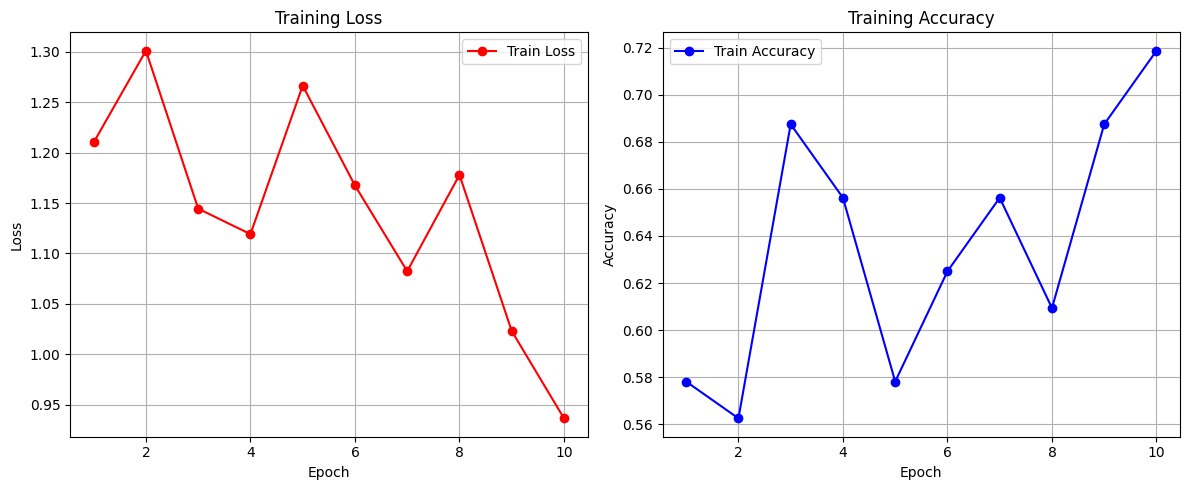

In [25]:
import matplotlib.pyplot as plt

# =======================
# Initialize lists to store metrics
# =======================
train_losses = []
train_accuracies = []

# =======================
# Training loop with metrics storage
# =======================
for epoch in range(epochs):
    model.train()
    running_loss, running_correct, processed_images = 0.0, 0, 0

    for step, (imgs, labels) in enumerate(train_loader):
        if step >= steps_per_epoch:
            break

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(1) == labels).sum().item()
        processed_images += batch_size

    # Epoch metrics
    epoch_loss = running_loss / processed_images
    epoch_acc  = running_correct / processed_images

    # Store metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

# =======================
# Plot Loss and Accuracy
# =======================
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, marker='o', color='red', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, marker='o', color='blue', label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10 | Train Loss: 1.1012 | Train Acc: 0.6562 | Val Loss: 1.5481 | Val Acc: 0.4000
Validation loss improved, saving model...
Epoch 2/10 | Train Loss: 1.3483 | Train Acc: 0.5312 | Val Loss: 1.3487 | Val Acc: 0.4000
Validation loss improved, saving model...
Epoch 3/10 | Train Loss: 0.9801 | Train Acc: 0.7656 | Val Loss: 1.4076 | Val Acc: 0.4000
No improvement in validation loss for 1 epoch(s)
Epoch 4/10 | Train Loss: 1.2332 | Train Acc: 0.5469 | Val Loss: 1.4928 | Val Acc: 0.4000
No improvement in validation loss for 2 epoch(s)
Epoch 5/10 | Train Loss: 1.1156 | Train Acc: 0.6562 | Val Loss: 1.5685 | Val Acc: 0.4000
No improvement in validation loss for 3 epoch(s)
Early stopping triggered!


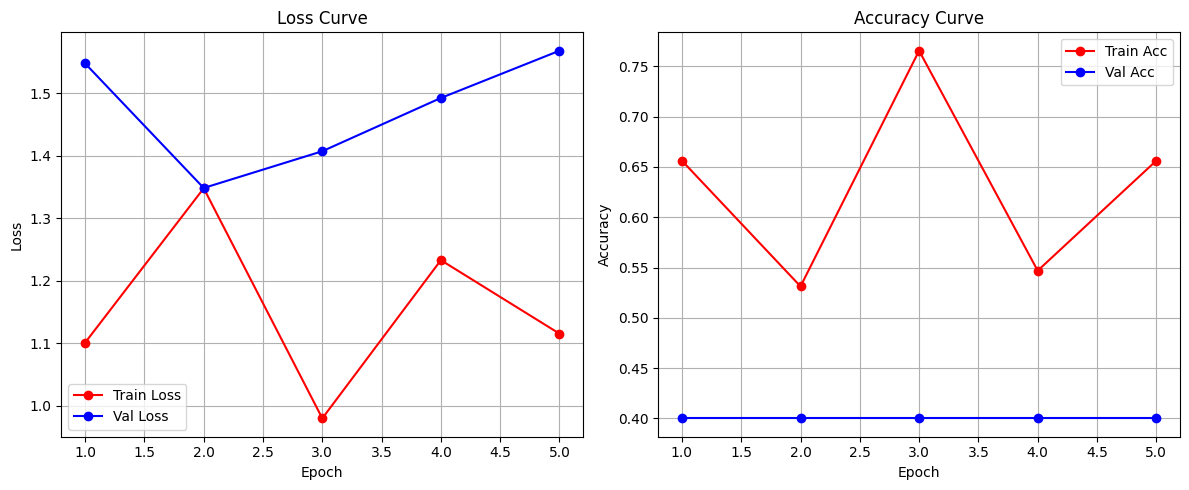

In [26]:
import matplotlib.pyplot as plt
import copy

# =======================
# Early Stopping Parameters
# =======================
patience = 3  # stop if validation loss does not improve for N epochs
best_val_loss = float('inf')
best_model_wts = None
counter = 0

# =======================
# Store metrics
# =======================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# =======================
# Training loop with early stopping
# =======================
for epoch in range(epochs):
    model.train()
    running_loss, running_correct, processed_images = 0.0, 0, 0

    for step, (imgs, labels) in enumerate(train_loader):
        if step >= steps_per_epoch:  # only ~40 images per epoch
            break
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(1) == labels).sum().item()
        processed_images += batch_size

    # Training metrics
    epoch_train_loss = running_loss / processed_images
    epoch_train_acc = running_correct / processed_images
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # =======================
    # Validation metrics
    # =======================
    model.eval()
    val_running_loss, val_running_correct, val_processed = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            batch_size = imgs.size(0)
            val_running_loss += loss.item() * batch_size
            val_running_correct += (outputs.argmax(1) == labels).sum().item()
            val_processed += batch_size

    epoch_val_loss = val_running_loss / val_processed
    epoch_val_acc = val_running_correct / val_processed
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # =======================
    # Early Stopping Check
    # =======================
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        print("Validation loss improved, saving model...")
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s)")
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model weights
if best_model_wts:
    model.load_state_dict(best_model_wts)

# =======================
# Plot training and validation curves
# =======================
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, marker='o', color='red', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', color='blue', label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, marker='o', color='red', label='Train Acc')
plt.plot(epochs_range, val_accuracies, marker='o', color='blue', label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


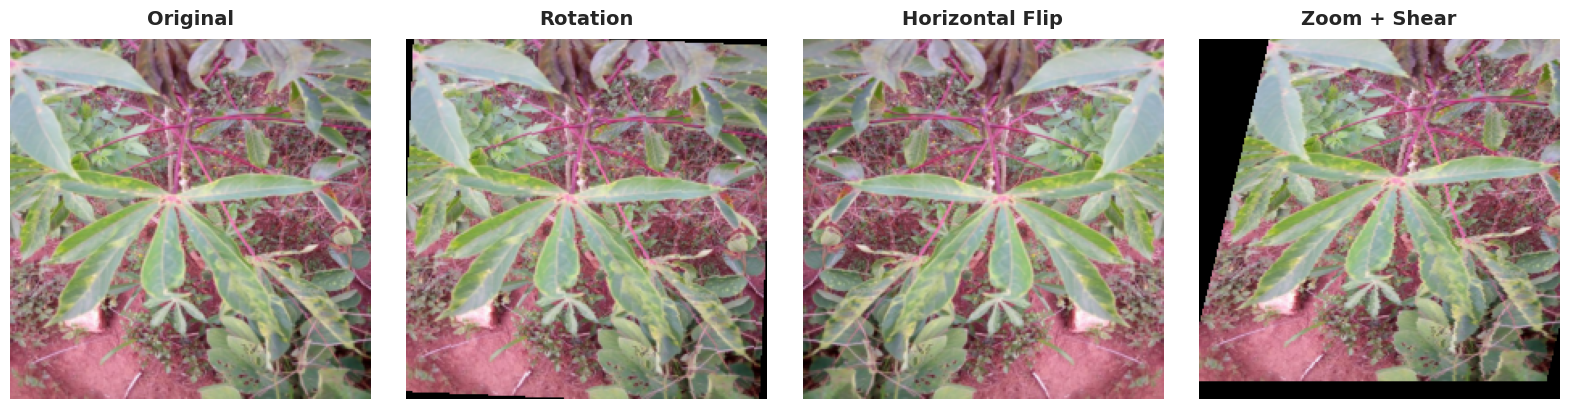

In [34]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
from PIL import Image
import numpy as np
import seaborn as sns
import os
import random

# Set style for clean visualizations
sns.set_style("white")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (16, 4)

# Find a valid image from your dataset
def find_sample_image(dataset_path):
    for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
        image_files = [f for f in os.listdir(dataset_path) if f.endswith(ext)]
        if image_files:
            return os.path.join(dataset_path, random.choice(image_files))
    return None

# Load a sample image from your dataset
sample_image_path = find_sample_image(train_images_path)
if sample_image_path:
    original_image = Image.open(sample_image_path).convert('RGB')
else:
    # Create a fallback demonstration image
    original_image = Image.new('RGB', (256, 256), color='lightblue')
    from PIL import ImageDraw
    draw = ImageDraw.Draw(original_image)
    draw.rectangle([50, 50, 200, 200], fill='salmon', outline='darkred', width=3)
    draw.ellipse([100, 100, 150, 150], fill='lightgreen', outline='darkgreen', width=2)

# Define image size
im_size = 224

# Define individual augmentation transforms
augmentations = [
    ("Original", T.Compose([
        T.Resize((im_size, im_size)),
        T.ToTensor()
    ])),
    ("Rotation", T.Compose([
        T.Resize((im_size, im_size)),
        T.RandomRotation(20),
        T.ToTensor()
    ])),
    ("Horizontal Flip", T.Compose([
        T.Resize((im_size, im_size)),
        T.RandomHorizontalFlip(p=1.0),
        T.ToTensor()
    ])),
    ("Zoom + Shear", T.Compose([
        T.Resize((im_size, im_size)),
        T.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
        T.ToTensor()
    ]))
]

# Apply each augmentation
augmented_images = []
titles = []

for name, transform in augmentations:
    augmented_img = transform(original_image)
    augmented_images.append(augmented_img)
    titles.append(name)

# Convert to display format (denormalize if needed)
display_images = []
for img in augmented_images:
    display_img = img.permute(1, 2, 0).numpy()
    display_images.append(display_img)

# Create the visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (ax, img, title) in enumerate(zip(axes, display_images, titles)):
    ax.imshow(img)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#2E86AB')
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()

Number of classes: 5
Valid images found: 16898
Subset sizes -> Train: 1000, Val: 10, Test: 200
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]



=== Epoch 1/20 ===
Batch 1 | Batch Loss: 1.5728 | Cumulative Loss: 1.5728 | Cumulative Acc: 0.2188 | Processed: 32
Batch 2 | Batch Loss: 1.1702 | Cumulative Loss: 1.3715 | Cumulative Acc: 0.4219 | Processed: 64
Batch 3 | Batch Loss: 1.6883 | Cumulative Loss: 1.4771 | Cumulative Acc: 0.4375 | Processed: 96
Batch 4 | Batch Loss: 1.0030 | Cumulative Loss: 1.3586 | Cumulative Acc: 0.5000 | Processed: 128
Batch 5 | Batch Loss: 0.9833 | Cumulative Loss: 1.2835 | Cumulative Acc: 0.5312 | Processed: 160
Batch 6 | Batch Loss: 1.4377 | Cumulative Loss: 1.3092 | Cumulative Acc: 0.5417 | Processed: 192
Batch 7 | Batch Loss: 1.2690 | Cumulative Loss: 1.3035 | Cumulative Acc: 0.5491 | Processed: 224
Batch 8 | Batch Loss: 1.2291 | Cumulative Loss: 1.2942 | Cumulative Acc: 0.5508 | Processed: 256
Batch 9 | Batch Loss: 1.4271 | Cumulative Loss: 1.3089 | Cumulative Acc: 0.5556 | Processed: 288
Batch 10 | Batch Loss: 1.0096 | Cumulative Loss: 1.2790 | Cumulative Acc: 0.5719 | Processed: 320
Batch 11 | B

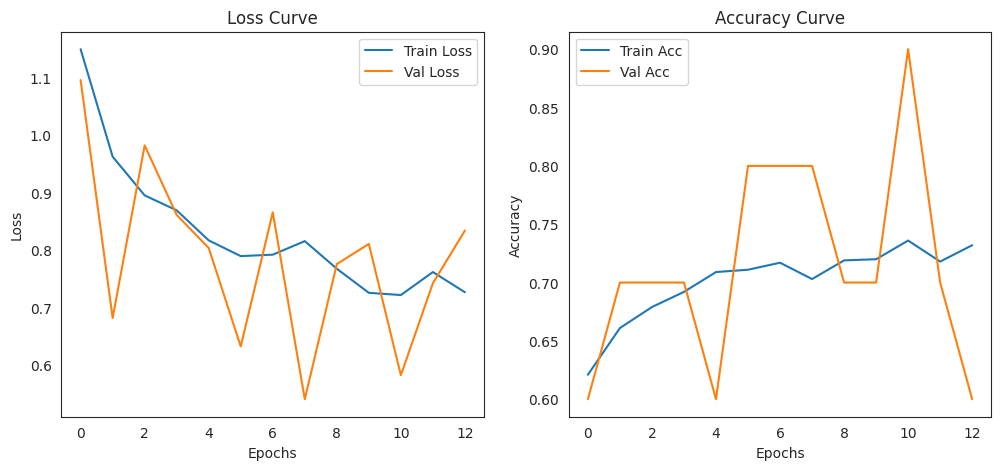

In [39]:
# =======================
# Imports
# =======================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T, models
from PIL import Image
import pandas as pd
import json
import matplotlib.pyplot as plt

# =======================
# Paths
# =======================
train_csv_path = "/content/drive/MyDrive/Dataset/train/other/train.csv"
train_images_path = "/content/drive/MyDrive/Dataset/train/train_data"
label_map_path = "/content/drive/MyDrive/Dataset/train/other/label_num_to_disease_map.json"

# =======================
# Load classes
# =======================
with open(label_map_path, "r") as f:
    label_map = json.load(f)
classes = list(label_map.values())
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

# =======================
# Custom Dataset
# =======================
class CustomDataset(Dataset):
    def __init__(self, root, csv_path, transform=None):
        self.root = root
        self.transform = transform
        self.data = pd.read_csv(csv_path)

        # Keep only existing files
        self.data = self.data[self.data.iloc[:, 0].apply(
            lambda x: os.path.exists(os.path.join(self.root, x))
        )].reset_index(drop=True)
        print(f"Valid images found: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.root, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# =======================
# Transformations
# =======================
train_tfs = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(20),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.2,0.2), shear=20),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfs = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# =======================
# Load dataset & split
# =======================
ds = CustomDataset(train_images_path, train_csv_path, transform=train_tfs)

# Subset split: 1000 train, 10 val, 200 test
subset_size = 1000 + 10 + 200
total_size = len(ds)
small_ds, _ = random_split(ds, [subset_size, total_size - subset_size])
train_ds, val_ds, test_ds = random_split(small_ds, [1000, 10, 200])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=10, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Subset sizes -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# =======================
# Load Pretrained ResNet50
# =======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

resnet = models.resnet50(pretrained=True)

# Freeze backbone
for param in resnet.parameters():
    param.requires_grad = False

# Replace classifier
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

# =======================
# Training with Early Stopping
# =======================
epochs = 20
patience = 5
best_val_loss = float('inf')
not_improved = 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    resnet.train()
    running_loss, running_correct, total_samples = 0.0, 0, 0
    print(f"\n=== Epoch {epoch+1}/{epochs} ===")

    for step, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += batch_size

        print(f"Batch {step+1} | Batch Loss: {loss.item():.4f} | "
              f"Cumulative Loss: {running_loss/total_samples:.4f} | "
              f"Cumulative Acc: {running_correct/total_samples:.4f} | "
              f"Processed: {total_samples}")

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_correct / total_samples
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    resnet.eval()
    val_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = resnet(imgs)
            loss = criterion(outputs, labels)
            batch_size = imgs.size(0)
            val_loss += loss.item() * batch_size
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_samples += batch_size

    val_epoch_loss = val_loss / val_samples
    val_epoch_acc  = val_correct / val_samples
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f"--- Epoch {epoch+1} Summary ---")
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        not_improved = 0
        torch.save(resnet.state_dict(), "best_resnet50.pth")
        print("Saved best model!")
    else:
        not_improved += 1
        print(f"No improvement for {not_improved} epoch(s)")
        if not_improved >= patience:
            print("Early stopping triggered!")
            break

# =======================
# Plot learning curves
# =======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()
